In [2]:
import networkx as nx
import random
import math
import copy
from matplotlib import pyplot as plt

In [3]:
def euclid_distance(u_x: float,
                    u_y: float,
                    v_x: float,
                    v_y: float) -> float:
    return math.sqrt((u_x - v_x)**2 + (u_y - v_y)**2)

In [4]:
def read_instance(file_path: str) -> nx.Graph:
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y = [float(a) for a in line.split()]
                g.add_node(int(node_id) - 1, x=x, y=y)
        
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                
                g.add_edge(u, v, weight=weight, pheromones=1)
                
        return g

In [5]:
g0 = read_instance(file_path='dj38.tsp')

In [6]:
g1 = read_instance(file_path='att48.tsp')

In [7]:
class Harmony: 
    def __init__(self, g : nx.Graph, cycleList : list):
        if(cycleList == None):
            self.cycle, self.fitness = self.hamiltonian(g)
        else:
            self.cycle, self.fitness = self.calcFitness(cycleList, g)
    
    def __str__(self):
        return ' '.join([str(u) for u in self.cycle]) + f' {self.fitness}'
    
    def __getitem__(self,index):
        return self.cycle[index]
    
    start=0
    
    def hamiltonian(self, g: nx.Graph):
        start = self.start
        cycle = [start]
        cycle_weight = 0
        visited = {start}
        u = start
        while len(visited) != len(g.nodes):
            neighbours = [v for v in g[u] if v not in visited]
            chosen_neighbour = random.choices(neighbours, weights=None, k=1)[0]
            cycle.append(chosen_neighbour)
            visited.add(chosen_neighbour)
            cycle_weight += g[u][chosen_neighbour]['weight']
            u = chosen_neighbour
        
        cycle_weight += g[start][cycle[-1]]['weight']
        return cycle, cycle_weight
    
    def calcFitness(self, cycleList : list, g : nx.Graph):
        fitness = g[cycleList[0]][cycleList[-1]]['weight']
        for u, v in zip(cycleList[:-1], cycleList[1:]):
            fitness += g[u][v]['weight']
        return cycleList, fitness

In [26]:
def HarmonySearch(
    g: nx.Graph,
    HMS: int, #number of harmonies
    HMCR: float, #harmony memory accepting rate
    PAR: float, #pitch adjusting rate
    R: int,
    rho: float,
    theta: float,
    maxIterations: int
):
    HarmonyMemory = [Harmony(g, None) for _ in range(HMS)]
    HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
    
    c = 0
    gc = 0
    bestOfHM = []
    iterationsFromLastReplacement = 0
    bestHarmony = HarmonyMemory[0]
    
    for t in range(maxIterations):
        numOfCities = len(g.nodes())
        
        pheromoneUpdate(g, HarmonyMemory, rho, theta)
        
        harmonyCycle = []
        for i in range(numOfCities):
             
            if random.random() < HMCR:
                #chose a value from HM for the variable i (play same harmony)
                harmonyCycle = chooseFromHM(g, HarmonyMemory, harmonyCycle, i)
                if random.random() < PAR:
                    #adjust the value (improvise on harmony)
                    harmonyCycle = adjustHarmony(harmonyCycle, g)
            else:
                #chose random harmony (improvise)
                harmonyCycle = improvise(harmonyCycle, g)
            
            if len(harmonyCycle) != i+1 : #node doesnt have unvisited neighbor
                break
            
        #accept solution if better than worst
        #(calc fitness and sort hm fitnesses)
        if len(g.nodes) != len(harmonyCycle):
            c+=1
            continue
        
        newHarmony = Harmony(g, harmonyCycle)
        
        if(newHarmony.fitness < HarmonyMemory[HMS-1].fitness):
            
            HarmonyMemory.remove(HarmonyMemory[HMS-1])
            HarmonyMemory.append(newHarmony)
            HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
            gc += 1
            
            if HarmonyMemory[0].fitness < bestHarmony.fitness:
                bestHarmony = HarmonyMemory[0]
            
            iterationsFromLastReplacement = 0
        else:
            iterationsFromLastReplacement += 1
            
        bestOfHM.append(sum([f.fitness for f in HarmonyMemory[0:3]])/3)
            
        
        if iterationsFromLastReplacement == R:
            HarmonyMemory = [Harmony(g, None) for _ in range(HMS)]
            HarmonyMemory.sort(key= lambda x : x.fitness, reverse=False)
        
    print('Cycles founded: ', maxIterations-c)
    print('Good cycles founded: ', gc)
        
    plt.plot(range(len(bestOfHM)), bestOfHM)
        
    #return best solution
             
    return bestHarmony

In [9]:
def chooseFromHM(g: nx.Graph, HarmonyMemory: list, harmony: list, i: int) -> list: #TODO test
    candidates = []
    weights = []
    maxF = 0
    
    for h in HarmonyMemory:
        if h[i] not in harmony:
            candidates.append(h[i])
            weights.append(h.fitness)
            if h.fitness > maxF:
                maxF = h.fitness
    if len(candidates) == 0:
        #pheromone based best
        maxPheromones = -1
        bestNode = None
        for u in g.nodes():
            if u not in harmony:
                if g[harmony[-1]][u]['pheromones'] > maxPheromones:
                    maxPheromones = g[harmony[-1]][u]['pheromones']
                    bestNode = u
        harmony.append(bestNode)
        return harmony
    
    weights[:] = [w/maxF for w in weights]
    harmony.append(random.choices(candidates, weights=weights, k=1)[0])
    return harmony

In [10]:
def adjustHarmony(harmony : list, g : nx.Graph) -> list:
    
    neighbors = [u for u in g.neighbors(harmony[-1])]
    
    #random.shuffle(neighbors)
    neighbors.sort(key = lambda x: g[harmony[-1]][x]['weight'])
    
    for u in neighbors:
        if u not in harmony:
            harmony.remove(harmony[-1])
            harmony.append(u)
            return harmony
    return harmony

In [11]:
def improvise(harmony: list, g: nx.Graph) -> list:
    
    
    candidates = [c for c in g.nodes()]
    
    random.shuffle(candidates)
    
    for c in candidates:
        if c not in harmony:
            harmony.append(c)
            return harmony
    return harmony

In [12]:
def pheromoneUpdate(g: nx.Graph, HarmonyMemory: list, rho, theta):
    for u in range(len(g.nodes())):
            for v in range(u + 1, len(g.nodes())):
                g[u][v]['pheromones'] *= rho
                
    for h in HarmonyMemory:
            delta = theta / h.fitness
            for u, v in zip(h.cycle[:-1], h.cycle[1:]):
                g[u][v]['pheromones'] += delta
            g[h.cycle[0]][h.cycle[-1]]['pheromones'] += delta

Cycles founded:  10000
Good cycles founded:  360
23 6 0 9 13 25 19 21 17 16 18 10 11 7 14 27 30 33 32 34 31 29 20 12 8 5 4 2 3 1 28 24 22 15 37 36 35 26 13525.97038147775


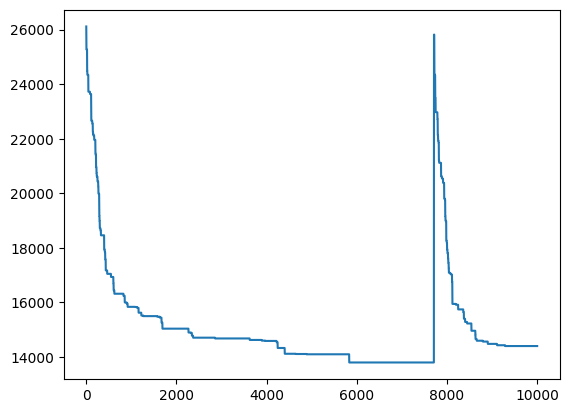

In [27]:
HMS = 10
HMCR = 0.98
PAR = 0.5

R = 1000

rho = 0.1
theta = 100.0

maxIterations = 10000
print(HarmonySearch(g0, HMS, HMCR, PAR, R, rho, theta, maxIterations))